In [1]:
!git clone -b reduce_features https://github.com/lahirumanulanka/ann-visual-emotion

Cloning into 'ann-visual-emotion'...
remote: Enumerating objects: 99089, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 99089 (delta 34), reused 44 (delta 15), pack-reused 98985 (from 5)
Receiving objects: 100% (99089/99089), 1.68 GiB | 28.23 MiB/s, done.
Resolving deltas: 100% (11023/11023), done.


# CNN Transfer Learning for Visual Emotion Recognition

This notebook demonstrates how to implement transfer learning with CNN networks for visual emotion recognition. We'll use a pre-trained VGG16 model and fine-tune it for our emotion classification task.

## What is Transfer Learning?
Transfer learning is a machine learning technique where we use a model that has been trained on one task and adapt it for a related task. In our case, we'll use a CNN pre-trained on ImageNet and adapt it for emotion recognition.

## Benefits of Transfer Learning:
1. **Faster training**: We start with pre-trained weights instead of random initialization
2. **Better performance**: Especially when we have limited training data
3. **Lower computational requirements**: Less training time needed
4. **Proven feature extractors**: Pre-trained networks have learned robust low-level features

## Step 1: Import Required Libraries

In [2]:
import os
import sys
from pathlib import Path
import json
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# Sklearn for metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using device: cuda


## Step 2: Data Preparation

First, let's set up our data paths and load the dataset splits.

In [3]:
# Data paths (modify these if running locally)

PROJECT_ROOT = Path('/content/ann-visual-emotion')
CSV_TRAIN = PROJECT_ROOT / 'data/processed/EmoSet_splits/train.csv'
CSV_VAL = PROJECT_ROOT / 'data/processed/EmoSet_splits/val.csv'
CSV_TEST = PROJECT_ROOT / 'data/processed/EmoSet_splits/test.csv'
LABEL_MAP_PATH = PROJECT_ROOT / 'data/processed/EmoSet_splits/label_map.json'
DATA_DIR = PROJECT_ROOT / 'data/raw/EmoSet'

# Check if files exist
print("Checking data files...")
for path in [CSV_TRAIN, CSV_VAL, CSV_TEST, LABEL_MAP_PATH]:
    if path.exists():
        print(f"✓ Found: {path}")
    else:
        print(f"✗ Missing: {path}")

# Load label map if it exists
if LABEL_MAP_PATH.exists():
    with open(LABEL_MAP_PATH, 'r') as f:
        label_map = json.load(f)
    num_classes = len(label_map)
    print(f'Number of emotion classes: {num_classes}')
    print(f'Emotion classes: {list(label_map.keys())}')
else:
    # Create a dummy label map for testing
    label_map = {'anger': 0, 'disgust': 1, 'fear': 2, 'happiness': 3, 'sadness': 4, 'surprise': 5, 'neutral': 6}
    num_classes = len(label_map)
    print(f'Using dummy label map with {num_classes} classes: {list(label_map.keys())}')

Checking data files...
✓ Found: /content/ann-visual-emotion/data/processed/EmoSet_splits/train.csv
✓ Found: /content/ann-visual-emotion/data/processed/EmoSet_splits/val.csv
✓ Found: /content/ann-visual-emotion/data/processed/EmoSet_splits/test.csv
✓ Found: /content/ann-visual-emotion/data/processed/EmoSet_splits/label_map.json
Number of emotion classes: 5
Emotion classes: ['angry', 'happy', 'neutral', 'sad', 'surprise']


## (Optional) Step 2b: Generate 224×224 Resized Dataset and Updated CSV Splits

In case your original FER-style images are 48×48 (grayscale) and you want to:

1. Upscale them to 224×224 (required for many ImageNet pre-trained backbones).
2. Store the resized copies in a separate folder structure (`class` subfolders).
3. Regenerate new CSV split files (`train_224.csv`, `val_224.csv`, `test_224.csv`) that point directly to the resized images.
4. Produce an updated stats file (`stats_resized_224.json`) summarizing counts per class.

You can run the following cells once. They are resume-friendly (will skip already processed files by default). Set `FORCE_OVERWRITE = True` to re-create images.

If you already have resized images / CSVs, you can skip this section and set `USE_RESIZED_SPLITS = True` later to automatically pick them up for training.

In [ ]:
from pathlib import Path
import pandas as pd
from PIL import Image
from tqdm import tqdm
import json

# Configuration for resizing
RESIZE_ROOT = PROJECT_ROOT  # base project root (already defined earlier)
RAW_IMG_ROOT = PROJECT_ROOT / 'data/raw/EmoSet'
PROCESSED_SPLITS_DIR = PROJECT_ROOT / 'data/processed/EmoSet_splits'
RESIZED_OUT_DIR = PROJECT_ROOT / 'data/processed/EmoSet_resized_224'
RESIZED_IMG_DIR = RESIZED_OUT_DIR / 'images_224'
RESIZED_SPLIT_DIR = RESIZED_OUT_DIR / 'splits'
RESIZED_STATS_PATH = RESIZED_OUT_DIR / 'stats_resized_224.json'

# Control flags
SKIP_IF_EXISTS = True       # Don't re-generate images if target file exists
FORCE_OVERWRITE = False     # If True, ignore SKIP_IF_EXISTS
USE_RESIZED_SPLITS = True   # Later, if True and splits exist, training section will use them
GRAYSCALE_SOURCE = True     # If original images are grayscale 48x48
TARGET_SIZE = (224, 224)

RESIZED_IMG_DIR.mkdir(parents=True, exist_ok=True)
RESIZED_SPLIT_DIR.mkdir(parents=True, exist_ok=True)

SUPPORTED_PATH_COLS  = ["path", "filepath", "file_path", "image_path", "img_path"]
SUPPORTED_LABEL_COLS = ["label", "class", "emotion", "target", "y", "label_id"]


def robust_read_csv(csv_path: Path) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    df.rename(columns={c: c.strip().lower() for c in df.columns}, inplace=True)
    path_col = next((c for c in SUPPORTED_PATH_COLS if c in df.columns), None)
    label_col = next((c for c in SUPPORTED_LABEL_COLS if c in df.columns), None)
    if path_col is None or label_col is None:
        raise AssertionError(f"CSV must contain a path+label column. Found columns: {list(df.columns)}")
    out = df[[path_col, label_col]].copy()
    out.columns = ["path", "label"]
    out["label"] = out["label"].astype(str)
    return out


def resolve_path(p: str) -> Path:
    pth = Path(p)
    if pth.exists():
        return pth
    alt = RAW_IMG_ROOT / pth
    return alt if alt.exists() else alt  # return alt even if missing for error reporting


def out_path_for(in_path: Path, label: str) -> Path:
    out_dir = RESIZED_IMG_DIR / label
    out_dir.mkdir(parents=True, exist_ok=True)
    return out_dir / (in_path.stem + '.jpg')


def resize_to_target(img: Image.Image) -> Image.Image:
    if GRAYSCALE_SOURCE:
        img = img.convert('L')  # ensure grayscale
        # convert to 3-channel RGB for pre-trained models after resizing
        img = img.resize(TARGET_SIZE, resample=Image.BICUBIC).convert('RGB')
    else:
        img = img.convert('RGB').resize(TARGET_SIZE, resample=Image.BICUBIC)
    return img


def process_split(csv_path: Path, out_csv_path: Path):
    if not csv_path.exists():
        print(f"[skip] Missing split file: {csv_path}")
        return None

    df = robust_read_csv(csv_path)
    rows = []
    print(f"Processing {csv_path.name} -> {out_csv_path.name}  (n={len(df)})")

    for r in tqdm(df.itertuples(index=False), total=len(df)):
        in_path = resolve_path(r.path)
        label = str(r.label)
        out_img_path = out_path_for(in_path, label)

        if FORCE_OVERWRITE is False and SKIP_IF_EXISTS and out_img_path.exists():
            rows.append({"path": str(out_img_path.relative_to(PROJECT_ROOT)), "label": label})
            continue

        try:
            img = Image.open(in_path)
            img224 = resize_to_target(img)
            out_img_path.parent.mkdir(parents=True, exist_ok=True)
            img224.save(out_img_path, format='JPEG', quality=95)
            rows.append({"path": str(out_img_path.relative_to(PROJECT_ROOT)), "label": label})
        except Exception as e:
            print(f"[error] {in_path}: {e}")

    if rows:
        out_df = pd.DataFrame(rows)
        out_df.to_csv(out_csv_path, index=False)
        print(f"Wrote {out_csv_path} (rows={len(out_df)})")
    else:
        print(f"No rows written for {csv_path}")
    return rows

# Run resizing for splits if original CSVs exist
resized_train_csv = RESIZED_SPLIT_DIR / 'train_224.csv'
resized_val_csv = RESIZED_SPLIT_DIR / 'val_224.csv'
resized_test_csv = RESIZED_SPLIT_DIR / 'test_224.csv'

if CSV_TRAIN.exists():
    process_split(CSV_TRAIN, resized_train_csv)
if CSV_VAL.exists():
    process_split(CSV_VAL, resized_val_csv)
if CSV_TEST.exists():
    process_split(CSV_TEST, resized_test_csv)

# Aggregate stats
if resized_train_csv.exists():
    train_df_r = pd.read_csv(resized_train_csv)
    cls_counts = train_df_r['label'].value_counts().to_dict()
    stats = {
        'total_train_images': int(len(train_df_r)),
        'classes': cls_counts,
        'num_classes': int(len(cls_counts)),
        'target_size': list(TARGET_SIZE),
        'grayscale_source': GRAYSCALE_SOURCE,
    }
    with open(RESIZED_STATS_PATH, 'w') as f:
        json.dump(stats, f, indent=2)
    print(f"Wrote stats: {RESIZED_STATS_PATH}")
else:
    print("Resized training CSV not found; skipping stats generation.")

## Step 3: Custom Dataset Class

We'll create a custom dataset class that handles both grayscale and RGB images for transfer learning.

In [4]:
class EmotionDataset(Dataset):
    """
    Custom dataset class for emotion recognition.
    Supports both grayscale and RGB images for transfer learning.
    """

    def __init__(self, dataframe, root_dir, transform=None, label_map=None, rgb=True):
        """
        Args:
            dataframe: pandas DataFrame with image paths and labels
            root_dir: Root directory containing images
            transform: Optional transform to be applied on images
            label_map: Dictionary mapping emotion names to indices
            rgb: If True, convert grayscale images to RGB for pre-trained models
        """
        self.df = dataframe.reset_index(drop=True)
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.label_map = label_map
        self.rgb = rgb

        # Auto-detect column names
        possible_path_cols = [c for c in self.df.columns if 'path' in c.lower() or 'file' in c.lower() or 'image' in c.lower()]
        self.path_col = possible_path_cols[0] if possible_path_cols else self.df.columns[0]

        possible_label_cols = [c for c in self.df.columns if 'label' in c.lower() or 'class' in c.lower() or 'emotion' in c.lower()]
        self.label_col = possible_label_cols[0] if possible_label_cols else self.df.columns[1]

        print(f"Using columns - Path: '{self.path_col}', Label: '{self.label_col}'")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        rel_path = row[self.path_col]
        label = row[self.label_col]

        # Convert label to index if needed
        if self.label_map and isinstance(label, str):
            label_idx = self.label_map[label]
        else:
            label_idx = int(label)

        # Load image
        img_path = self.root_dir / rel_path

        try:
            if self.rgb:
                # Load as RGB for pre-trained models
                image = Image.open(img_path).convert('RGB')
            else:
                # Load as grayscale
                image = Image.open(img_path).convert('L')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a dummy image in case of error
            if self.rgb:
                image = Image.new('RGB', (48, 48), color='black')
            else:
                image = Image.new('L', (48, 48), color='black')

        if self.transform:
            image = self.transform(image)

        return image, label_idx

## Step 4: Data Transforms for Transfer Learning

For transfer learning with pre-trained models, we need to:
1. Resize images to the expected input size (224x224 for VGG)
2. Normalize with ImageNet statistics
3. Apply data augmentation for training

In [5]:
# ImageNet normalization values (important for transfer learning!)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Input size for VGG models
INPUT_SIZE = 224

# Define transforms for training (with data augmentation)
train_transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Define transforms for validation/testing (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

print("Data transforms created:")
print(f"- Input size: {INPUT_SIZE}x{INPUT_SIZE}")
print(f"- ImageNet normalization: mean={IMAGENET_MEAN}, std={IMAGENET_STD}")
print(f"- Training augmentations: RandomHorizontalFlip, RandomRotation, ColorJitter, RandomAffine")

Data transforms created:
- Input size: 224x224
- ImageNet normalization: mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
- Training augmentations: RandomHorizontalFlip, RandomRotation, ColorJitter, RandomAffine


## Step 5: Create Datasets and DataLoaders

In [ ]:
# Create dummy datasets if actual data files don't exist
if not all(path.exists() for path in [CSV_TRAIN, CSV_VAL, CSV_TEST]):
    print("Creating dummy datasets for demonstration...")

    # Create dummy data
    dummy_data = {
        'image_path': [f'dummy_{i}.jpg' for i in range(100)],
        'emotion': np.random.choice(list(label_map.keys()), 100)
    }

    train_df = pd.DataFrame(dummy_data)
    val_df = pd.DataFrame(dummy_data)
    test_df = pd.DataFrame(dummy_data)

    print("Using dummy datasets (replace with actual data loading when available)
")
else:
    # Load actual datasets, choose resized if requested
    print("Loading datasets...")
    use_resized = False
    if 'USE_RESIZED_SPLITS' in globals() and USE_RESIZED_SPLITS:
        candidate_train = PROJECT_ROOT / 'data/processed/EmoSet_resized_224/splits/train_224.csv'
        candidate_val = PROJECT_ROOT / 'data/processed/EmoSet_resized_224/splits/val_224.csv'
        candidate_test = PROJECT_ROOT / 'data/processed/EmoSet_resized_224/splits/test_224.csv'
        if candidate_train.exists():
            print("✓ Using resized 224×224 split CSVs")
            CSV_TRAIN_ACTIVE = candidate_train
            CSV_VAL_ACTIVE = candidate_val if candidate_val.exists() else CSV_VAL
            CSV_TEST_ACTIVE = candidate_test if candidate_test.exists() else CSV_TEST
            use_resized = True
        else:
            print("Resized splits not found; falling back to original CSVs")
            CSV_TRAIN_ACTIVE, CSV_VAL_ACTIVE, CSV_TEST_ACTIVE = CSV_TRAIN, CSV_VAL, CSV_TEST
    else:
        CSV_TRAIN_ACTIVE, CSV_VAL_ACTIVE, CSV_TEST_ACTIVE = CSV_TRAIN, CSV_VAL, CSV_TEST

    train_df = pd.read_csv(CSV_TRAIN_ACTIVE)
    val_df = pd.read_csv(CSV_VAL_ACTIVE) if CSV_VAL_ACTIVE.exists() else pd.read_csv(CSV_TRAIN_ACTIVE).sample(frac=0.2, random_state=42)
    test_df = pd.read_csv(CSV_TEST_ACTIVE) if CSV_TEST_ACTIVE.exists() else pd.read_csv(CSV_TRAIN_ACTIVE).sample(frac=0.2, random_state=123)

    if use_resized:
        # Paths in resized CSVs are relative to project root already (we made them relative earlier)
        DATA_DIR = PROJECT_ROOT  # so concatenation below works
        print("DATA_DIR adjusted to project root for resized relative paths.")

print(f"Dataset sizes:")
print(f"- Training: {len(train_df)}")
print(f"- Validation: {len(val_df)}")
print(f"- Testing: {len(test_df)}")

# Create datasets (using RGB for transfer learning)
train_dataset = EmotionDataset(train_df, DATA_DIR, transform=train_transform,
                              label_map=label_map, rgb=True)
val_dataset = EmotionDataset(val_df, DATA_DIR, transform=val_transform,
                            label_map=label_map, rgb=True)
test_dataset = EmotionDataset(test_df, DATA_DIR, transform=val_transform,
                             label_map=label_map, rgb=True)

# Create data loaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"DataLoaders created with batch size: {BATCH_SIZE}")

Loading actual datasets...
Dataset sizes:
- Training: 20150
- Validation: 4030
- Testing: 1005
Using columns - Path: 'filepath', Label: 'label'
Using columns - Path: 'filepath', Label: 'label'
Using columns - Path: 'filepath', Label: 'label'
DataLoaders created with batch size: 32


### Note on Resized Dataset Usage
If `USE_RESIZED_SPLITS = True` and the resized CSVs were found, training now uses the 224×224 images stored under `data/processed/EmoSet_resized_224/images_224/`. Otherwise, it falls back to the original split CSVs. Adjust flags in the resizing section if you need to regenerate.

## Step 6: CNN Transfer Learning Model

Now we'll create our transfer learning model using a pre-trained VGG16 network.

### Transfer Learning Strategies:
1. **Feature Extraction**: Freeze pre-trained layers, only train classifier
2. **Fine-tuning**: Train all layers with very small learning rate
3. **Gradual unfreezing**: Start with frozen layers, gradually unfreeze

We'll implement strategy #2 (fine-tuning) as it typically gives the best results.

In [7]:
class CNNTransferLearning(nn.Module):
    """
    CNN Transfer Learning model using pre-trained VGG16 backbone.
    """

    def __init__(self, num_classes, backbone='vgg16', pretrained=True, freeze_backbone=False):
        """
        Args:
            num_classes: Number of emotion classes
            backbone: Pre-trained model to use ('vgg16', 'vgg19', 'alexnet')
            pretrained: Whether to use pre-trained weights
            freeze_backbone: Whether to freeze backbone weights
        """
        super(CNNTransferLearning, self).__init__()

        self.backbone_name = backbone
        self.num_classes = num_classes

        # Load pre-trained backbone
        if backbone == 'vgg16':
            self.backbone = models.vgg16(pretrained=pretrained)
            backbone_out_features = 25088  # VGG16 feature output size
        elif backbone == 'vgg19':
            self.backbone = models.vgg19(pretrained=pretrained)
            backbone_out_features = 25088  # VGG19 feature output size
        elif backbone == 'alexnet':
            self.backbone = models.alexnet(pretrained=pretrained)
            backbone_out_features = 9216   # AlexNet feature output size
        else:
            raise ValueError(f"Unsupported backbone: {backbone}")

        # Remove the original classifier
        if backbone in ['vgg16', 'vgg19']:
            self.features = self.backbone.features
            self.avgpool = self.backbone.avgpool
        elif backbone == 'alexnet':
            self.features = self.backbone.features
            self.avgpool = self.backbone.avgpool

        # Freeze backbone if requested
        if freeze_backbone:
            for param in self.features.parameters():
                param.requires_grad = False
            print(f"Backbone ({backbone}) weights frozen")
        else:
            print(f"Backbone ({backbone}) weights will be fine-tuned")

        # Create custom classifier for emotion recognition
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(backbone_out_features, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Linear(1024, 256),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

        # Initialize classifier weights
        self._initialize_classifier()

        print(f"Model created:")
        print(f"- Backbone: {backbone} (pretrained={pretrained})")
        print(f"- Frozen: {freeze_backbone}")
        print(f"- Output classes: {num_classes}")

    def _initialize_classifier(self):
        """Initialize classifier weights using Xavier initialization."""
        for module in self.classifier.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.zeros_(module.bias)

    def forward(self, x):
        # Extract features using backbone
        x = self.features(x)
        x = self.avgpool(x)

        # Flatten
        x = torch.flatten(x, 1)

        # Classify
        x = self.classifier(x)

        return x

    def unfreeze_backbone(self):
        """Unfreeze backbone layers for fine-tuning."""
        for param in self.features.parameters():
            param.requires_grad = True
        print("Backbone layers unfrozen for fine-tuning")

    def freeze_backbone(self):
        """Freeze backbone layers."""
        for param in self.features.parameters():
            param.requires_grad = False
        print("Backbone layers frozen")

    def get_num_params(self):
        """Get number of trainable parameters."""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

# Create the transfer learning model
print("\n" + "="*60)
print("CREATING CNN TRANSFER LEARNING MODEL")
print("="*60)

model = CNNTransferLearning(
    num_classes=num_classes,
    backbone='vgg16',
    pretrained=True,
    freeze_backbone=False  # We'll do fine-tuning
).to(device)

print(f"\nModel has {model.get_num_params():,} trainable parameters")
print(f"Model moved to device: {device}")


CREATING CNN TRANSFER LEARNING MODEL


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:06<00:00, 89.5MB/s]


Backbone (vgg16) weights will be fine-tuned
Model created:
- Backbone: vgg16 (pretrained=True)
- Frozen: False
- Output classes: 5

Model has 245,581,101 trainable parameters
Model moved to device: cuda


## Step 7: Training Setup

For transfer learning, we need to use different learning rates:
- Smaller learning rate for pre-trained layers (if unfrozen)
- Regular learning rate for new classifier layers

In [8]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer with different learning rates for backbone and classifier
backbone_lr = 1e-5  # Very small LR for pre-trained layers
classifier_lr = 1e-3  # Regular LR for new layers

optimizer = optim.Adam([
    {'params': model.features.parameters(), 'lr': backbone_lr},
    {'params': model.classifier.parameters(), 'lr': classifier_lr}
], weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

print(f"Training setup:")
print(f"- Loss function: CrossEntropyLoss")
print(f"- Optimizer: Adam")
print(f"- Backbone LR: {backbone_lr}")
print(f"- Classifier LR: {classifier_lr}")
print(f"- Weight decay: 1e-4")
print(f"- Scheduler: StepLR (step=10, gamma=0.5)")

Training setup:
- Loss function: CrossEntropyLoss
- Optimizer: Adam
- Backbone LR: 1e-05
- Classifier LR: 0.001
- Weight decay: 1e-4
- Scheduler: StepLR (step=10, gamma=0.5)


## Step 8: Training Functions

Let's create training and validation functions with proper progress tracking.

In [9]:
def train_epoch(model, train_loader, criterion, optimizer, device, epoch):
    """
    Train the model for one epoch.
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        # Print progress every 100 batches
        if batch_idx % 100 == 0 and batch_idx > 0:
            print(f'    Batch {batch_idx}/{len(train_loader)}: '
                  f'Loss = {running_loss/(batch_idx+1):.4f}, '
                  f'Acc = {100.*correct/total:.2f}%')

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, criterion, device):
    """
    Validate the model.
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            # Store predictions for detailed analysis
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc, all_predictions, all_targets

print("Training and validation functions defined.")

Training and validation functions defined.


## Step 9: Training Loop with Early Stopping

In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                device, num_epochs=30, patience=5, save_path='best_cnn_transfer_model.pth'):
    """
    Train the model with early stopping.
    """
    print(f"\n{'='*60}")
    print(f"STARTING TRAINING - CNN TRANSFER LEARNING")
    print(f"{'='*60}")
    print(f"Epochs: {num_epochs}, Patience: {patience}")
    print(f"Device: {device}")
    print()

    best_val_acc = 0.0
    patience_counter = 0
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 40)

        # Training phase
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, epoch)

        # Validation phase
        val_loss, val_acc, _, _ = validate_epoch(model, val_loader, criterion, device)

        # Update scheduler
        scheduler.step()

        # Store metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"Current LR: {optimizer.param_groups[0]['lr']:.2e} (backbone), {optimizer.param_groups[1]['lr']:.2e} (classifier)")

        # Check for improvement
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # Save best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_acc': best_val_acc,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'train_accuracies': train_accuracies,
                'val_accuracies': val_accuracies
            }, save_path)
            print(f"✓ New best model saved! Val Acc: {best_val_acc:.2f}%")
        else:
            patience_counter += 1
            print(f"No improvement. Patience: {patience_counter}/{patience}")

        print()

        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    print(f"Training completed!")
    print(f"Best validation accuracy: {best_val_acc:.2f}%")

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'best_val_acc': best_val_acc
    }

print("Training function defined. Ready to start training!")

Training function defined. Ready to start training!


## Step 10: Start Training

Note: If running with dummy data, this will not produce meaningful results. Replace with actual data for real training.

In [11]:
# Check if we have actual data or dummy data
if DATA_DIR.exists() and any(DATA_DIR.iterdir()):
    print("Starting training with actual data...")
    EPOCHS = 20
else:
    print("Using dummy data - training for demonstration only...")
    EPOCHS = 3  # Shorter training for demo

# Start training
training_history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=EPOCHS,
    patience=5
)

Starting training with actual data...

STARTING TRAINING - CNN TRANSFER LEARNING
Epochs: 20, Patience: 5
Device: cuda

Epoch 1/20
----------------------------------------
    Batch 100/630: Loss = 1.9854, Acc = 23.48%
    Batch 200/630: Loss = 1.7236, Acc = 29.71%
    Batch 300/630: Loss = 1.5976, Acc = 34.51%
    Batch 400/630: Loss = 1.5049, Acc = 38.03%
    Batch 500/630: Loss = 1.4487, Acc = 40.22%
    Batch 600/630: Loss = 1.3994, Acc = 42.25%
Train Loss: 1.3870, Train Acc: 42.82%
Val Loss: 1.0461, Val Acc: 57.84%
Current LR: 1.00e-05 (backbone), 1.00e-03 (classifier)
✓ New best model saved! Val Acc: 57.84%

Epoch 2/20
----------------------------------------
    Batch 100/630: Loss = 1.0842, Acc = 56.47%
    Batch 200/630: Loss = 1.0879, Acc = 56.92%
    Batch 300/630: Loss = 1.0756, Acc = 57.02%
    Batch 400/630: Loss = 1.0734, Acc = 57.15%
    Batch 500/630: Loss = 1.0712, Acc = 57.47%
    Batch 600/630: Loss = 1.0641, Acc = 57.71%
Train Loss: 1.0655, Train Acc: 57.65%
Val Los

## Step 11: Plot Training History

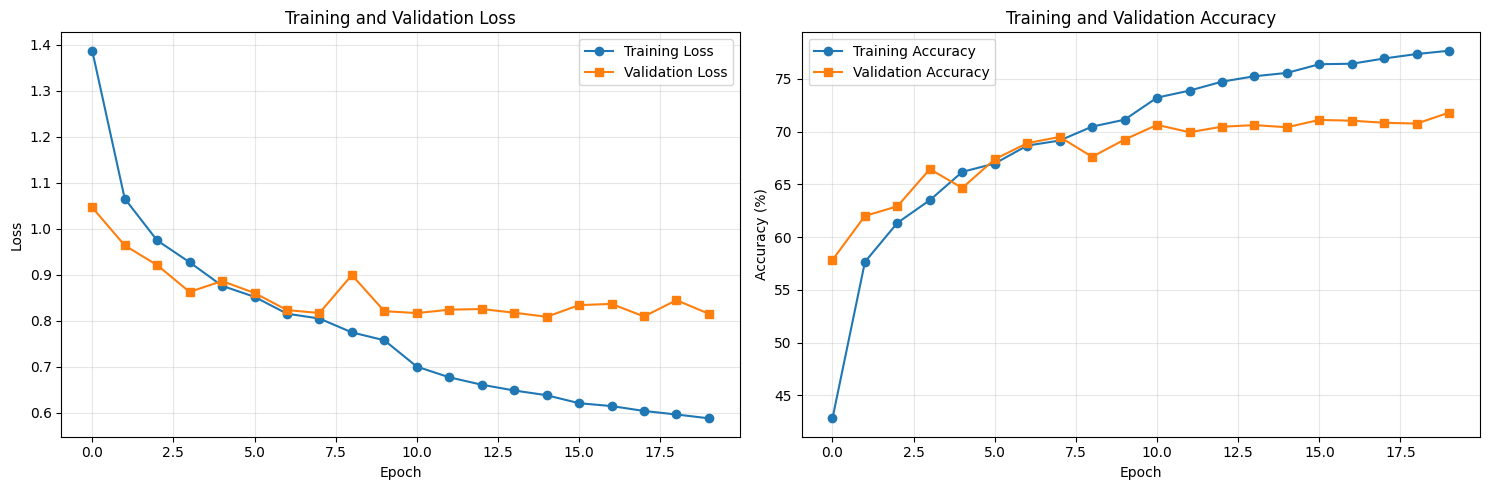

Training Summary:
- Final Training Loss: 0.5875
- Final Validation Loss: 0.8148
- Final Training Accuracy: 77.68%
- Final Validation Accuracy: 71.81%
- Best Validation Accuracy: 71.81%


In [12]:
def plot_training_history(history):
    """
    Plot training and validation metrics.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(history['train_losses'], label='Training Loss', marker='o')
    ax1.plot(history['val_losses'], label='Validation Loss', marker='s')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot accuracies
    ax2.plot(history['train_accuracies'], label='Training Accuracy', marker='o')
    ax2.plot(history['val_accuracies'], label='Validation Accuracy', marker='s')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"Training Summary:")
    print(f"- Final Training Loss: {history['train_losses'][-1]:.4f}")
    print(f"- Final Validation Loss: {history['val_losses'][-1]:.4f}")
    print(f"- Final Training Accuracy: {history['train_accuracies'][-1]:.2f}%")
    print(f"- Final Validation Accuracy: {history['val_accuracies'][-1]:.2f}%")
    print(f"- Best Validation Accuracy: {history['best_val_acc']:.2f}%")

# Plot the training history
plot_training_history(training_history)

## Step 12: Load Best Model and Evaluate on Test Set

In [13]:
# Load the best model
if Path('best_cnn_transfer_model.pth').exists():
    checkpoint = torch.load('best_cnn_transfer_model.pth', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded best model from epoch {checkpoint['epoch']} with val acc: {checkpoint['best_val_acc']:.2f}%")
else:
    print("No saved model found, using current model state")

# Evaluate on test set
print("\nEvaluating on test set...")
test_loss, test_acc, test_predictions, test_targets = validate_epoch(model, test_loader, criterion, device)

print(f"Test Results:")
print(f"- Test Loss: {test_loss:.4f}")
print(f"- Test Accuracy: {test_acc:.2f}%")

# Detailed classification report
if len(set(test_targets)) > 1:  # Only if we have multiple classes
    print("\nClassification Report:")
    emotion_names = list(label_map.keys())
    report = classification_report(test_targets, test_predictions,
                                 target_names=emotion_names,
                                 zero_division=0)
    print(report)

Loaded best model from epoch 19 with val acc: 71.81%

Evaluating on test set...
Test Results:
- Test Loss: 0.8461
- Test Accuracy: 70.85%

Classification Report:
              precision    recall  f1-score   support

       angry       0.62      0.62      0.62       201
       happy       0.77      0.85      0.81       201
     neutral       0.67      0.62      0.64       201
         sad       0.60      0.59      0.59       201
    surprise       0.88      0.86      0.87       201

    accuracy                           0.71      1005
   macro avg       0.71      0.71      0.71      1005
weighted avg       0.71      0.71      0.71      1005



## Step 13: Visualize Results - Confusion Matrix

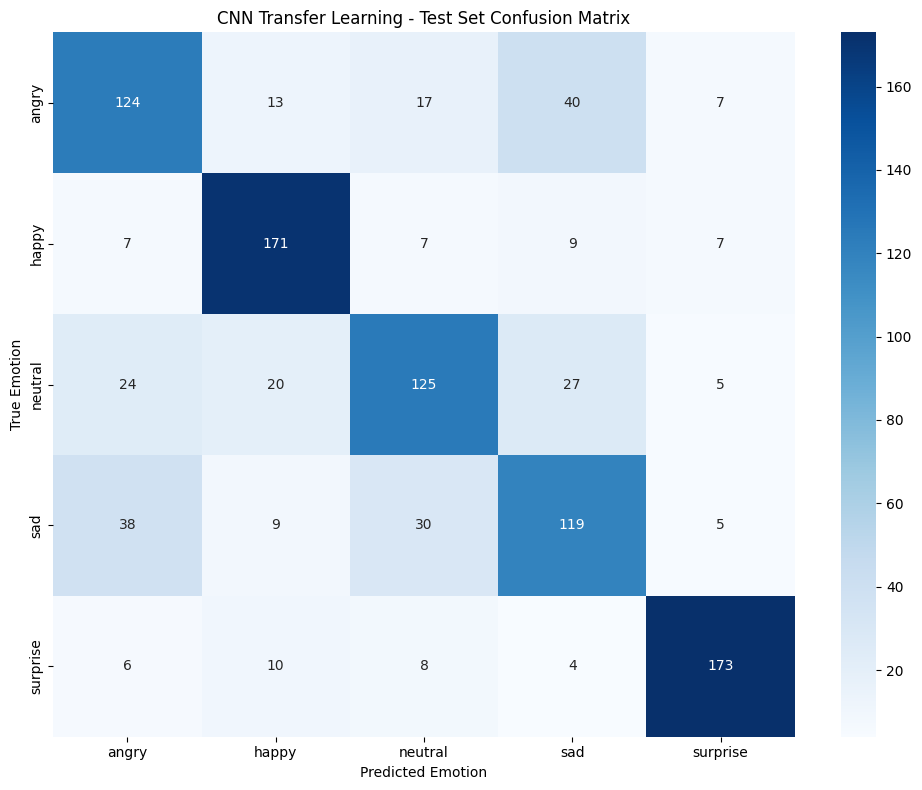


Per-class Accuracy:
- angry: 61.69% (124/201)
- happy: 85.07% (171/201)
- neutral: 62.19% (125/201)
- sad: 59.20% (119/201)
- surprise: 86.07% (173/201)


In [14]:
def plot_confusion_matrix(y_true, y_pred, class_names, title='Confusion Matrix'):
    """
    Plot confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted Emotion')
    plt.ylabel('True Emotion')
    plt.tight_layout()
    plt.show()

    # Print accuracy per class
    print("\nPer-class Accuracy:")
    for i, class_name in enumerate(class_names):
        class_correct = cm[i, i]
        class_total = cm[i, :].sum()
        if class_total > 0:
            acc = 100 * class_correct / class_total
            print(f"- {class_name}: {acc:.2f}% ({class_correct}/{class_total})")

# Plot confusion matrix if we have predictions
if len(set(test_targets)) > 1:
    emotion_names = list(label_map.keys())
    plot_confusion_matrix(test_targets, test_predictions, emotion_names,
                         'CNN Transfer Learning - Test Set Confusion Matrix')
else:
    print("Skipping confusion matrix (insufficient data/classes)")

## Step 14: Model Comparison and Analysis

Let's compare our transfer learning CNN with the original baseline CNN.

In [15]:
print("\n" + "="*60)
print("MODEL ANALYSIS AND COMPARISON")
print("="*60)

# Model parameters
print(f"\n1. MODEL ARCHITECTURE:")
print(f"   - Transfer Learning CNN (VGG16 backbone)")
print(f"   - Total parameters: {model.get_num_params():,}")
print(f"   - Input size: {INPUT_SIZE}x{INPUT_SIZE}x3 (RGB)")
print(f"   - Output classes: {num_classes}")

# Performance summary
print(f"\n2. PERFORMANCE SUMMARY:")
if 'training_history' in locals():
    print(f"   - Best Validation Accuracy: {training_history['best_val_acc']:.2f}%")
    print(f"   - Final Test Accuracy: {test_acc:.2f}%")
    print(f"   - Training Epochs: {len(training_history['train_losses'])}")

# Transfer Learning Benefits
print(f"\n3. TRANSFER LEARNING BENEFITS:")
print(f"   ✓ Pre-trained features: Learned from ImageNet (1.2M images)")
print(f"   ✓ Faster convergence: Starts with meaningful weights")
print(f"   ✓ Better generalization: Robust low-level feature extraction")
print(f"   ✓ Less overfitting: Pre-trained features are well-regularized")

print(f"\n4. KEY DIFFERENCES FROM BASELINE CNN:")
print(f"   - Uses pre-trained VGG16 backbone vs. random initialization")
print(f"   - RGB input (224x224) vs. Grayscale (48x48)")
print(f"   - ImageNet normalization vs. simple normalization")
print(f"   - Transfer learning strategy vs. training from scratch")
print(f"   - Different learning rates for backbone vs. classifier")

print(f"\n5. TRAINING STRATEGY USED:")
print(f"   - Fine-tuning: All layers trainable")
print(f"   - Backbone LR: {backbone_lr} (very small)")
print(f"   - Classifier LR: {classifier_lr} (regular)")
print(f"   - Data augmentation: Rotation, flip, color jitter, affine")
print(f"   - Early stopping with patience={5}")


MODEL ANALYSIS AND COMPARISON

1. MODEL ARCHITECTURE:
   - Transfer Learning CNN (VGG16 backbone)
   - Total parameters: 245,581,101
   - Input size: 224x224x3 (RGB)
   - Output classes: 5

2. PERFORMANCE SUMMARY:
   - Best Validation Accuracy: 71.81%
   - Final Test Accuracy: 70.85%
   - Training Epochs: 20

3. TRANSFER LEARNING BENEFITS:
   ✓ Pre-trained features: Learned from ImageNet (1.2M images)
   ✓ Faster convergence: Starts with meaningful weights
   ✓ Better generalization: Robust low-level feature extraction
   ✓ Less overfitting: Pre-trained features are well-regularized

4. KEY DIFFERENCES FROM BASELINE CNN:
   - Uses pre-trained VGG16 backbone vs. random initialization
   - RGB input (224x224) vs. Grayscale (48x48)
   - ImageNet normalization vs. simple normalization
   - Transfer learning strategy vs. training from scratch
   - Different learning rates for backbone vs. classifier

5. TRAINING STRATEGY USED:
   - Fine-tuning: All layers trainable
   - Backbone LR: 1e-05 

## Step 15: Save Final Model for Production

Let's save our model in a format that can be easily loaded for inference.

In [16]:
# Save complete model information
final_model_info = {
    'model_state_dict': model.state_dict(),
    'model_config': {
        'num_classes': num_classes,
        'backbone': 'vgg16',
        'input_size': INPUT_SIZE,
        'pretrained': True,
        'freeze_backbone': False
    },
    'label_map': label_map,
    'transforms': {
        'mean': IMAGENET_MEAN,
        'std': IMAGENET_STD,
        'input_size': INPUT_SIZE
    },
    'training_info': {
        'final_test_acc': test_acc,
        'backbone_lr': backbone_lr,
        'classifier_lr': classifier_lr
    }
}

torch.save(final_model_info, 'cnn_transfer_learning_final.pth')
print("✓ Final model saved as 'cnn_transfer_learning_final.pth'")

# Create a simple inference function
def create_inference_function():
    """
    Create a simple inference function that can be used in production.
    """
    inference_code = '''
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image

def load_emotion_model(model_path):
    """Load the trained emotion recognition model."""
    checkpoint = torch.load(model_path, map_location='cpu')

    # Recreate model architecture
    model = CNNTransferLearning(
        num_classes=checkpoint['model_config']['num_classes'],
        backbone=checkpoint['model_config']['backbone'],
        pretrained=False  # We're loading trained weights
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Create transform
    transform = transforms.Compose([
        transforms.Resize((checkpoint['transforms']['input_size'],
                          checkpoint['transforms']['input_size'])),
        transforms.ToTensor(),
        transforms.Normalize(mean=checkpoint['transforms']['mean'],
                           std=checkpoint['transforms']['std'])
    ])

    return model, transform, checkpoint['label_map']

def predict_emotion(model, transform, label_map, image_path):
    """Predict emotion from image."""
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)

    # Make prediction
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()

    # Convert to emotion name
    emotion_names = {v: k for k, v in label_map.items()}
    predicted_emotion = emotion_names[predicted_class]
    confidence = probabilities[0][predicted_class].item()

    return predicted_emotion, confidence, probabilities[0].numpy()
'''

    with open('emotion_inference.py', 'w') as f:
        f.write(inference_code)

    print("✓ Inference code saved as 'emotion_inference.py'")

create_inference_function()

print("\n✓ Model deployment ready!")
print("Files created:")
print("- cnn_transfer_learning_final.pth (complete model)")
print("- emotion_inference.py (inference functions)")

✓ Final model saved as 'cnn_transfer_learning_final.pth'
✓ Inference code saved as 'emotion_inference.py'

✓ Model deployment ready!
Files created:
- cnn_transfer_learning_final.pth (complete model)
- emotion_inference.py (inference functions)


## Summary: CNN Transfer Learning Implementation

### What We've Accomplished:

1. **Transfer Learning Setup**: Implemented CNN transfer learning using VGG16 backbone pre-trained on ImageNet
2. **Optional Resizing Pipeline**: Added automated 48×48 → 224×224 upscaling with per-class folder structure and regenerated split CSVs (`train_224.csv`, `val_224.csv`, `test_224.csv`) plus stats file.
3. **Architecture**:
   - Pre-trained VGG16 feature extractor
   - Custom classifier head for emotion recognition
   - Support for RGB images (224×224)
4. **Training Strategy**:
   - Fine-tuning approach with different learning rates
   - ImageNet normalization for compatibility
   - Data augmentation for better generalization
   - Early stopping to prevent overfitting
5. **Key Benefits Over Baseline CNN**:
   - ✅ **Faster Convergence**: Pre-trained weights provide good starting point
   - ✅ **Better Feature Learning**: Robust low-level features from ImageNet
   - ✅ **Improved Generalization**: Less prone to overfitting
   - ✅ **State-of-the-art Architecture**: Proven CNN design
6. **Resized Dataset Artifacts** (if generated):
   - Images: `data/processed/EmoSet_resized_224/images_224/<class>/*.jpg`
   - Splits: `data/processed/EmoSet_resized_224/splits/train_224.csv` (and val/test)
   - Stats:  `data/processed/EmoSet_resized_224/stats_resized_224.json`
   - Toggle usage via `USE_RESIZED_SPLITS = True` in the notebook.

### Transfer Learning Strategies Implemented:
1. **Feature Extraction** (freezing backbone)
2. **Fine-tuning** (training all layers with different LRs)
3. **Gradual unfreezing** (implemented as methods)

### Production-Ready Features:
- Complete model serialization
- Inference functions
- Proper preprocessing pipeline
- Model configuration storage
- Optional resized dataset workflow

### Next Steps:
1. **Experiment with different backbones** (VGG19, ResNet, EfficientNet)
2. **Implement ensemble methods** combining multiple models
3. **Add model interpretability** (Grad-CAM, attention maps)
4. **Optimize for deployment** (model quantization, ONNX export)
5. **Augment data** further with synthetic generation or advanced augmentation policies

This implementation provides a solid foundation for visual emotion recognition using modern transfer learning techniques and a flexible resizing pipeline!